### Imports

In [1]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

In [2]:
# We want to predict Claim Injury Type

### EDA will consiste of:
    - In-depth exploration of the dataset. 
    - Feature creation, in order to better explain the information
    - Find trends, patterns or anomalities.


In [3]:
# For this study we will consider all dates in reference to 25 of Dec of 2024
reference_date = pd.to_datetime("2023-12-25")
# this is to convert birth date into age and how much time has passed sim the different dates

### Import Train dataset and view

In [4]:
train_df = pd.read_csv("./data/train_data.csv", dtype={ 29 : str})

In [5]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [6]:
train_df["Claim Injury Type"].unique()

array(['2. NON-COMP', '4. TEMPORARY', nan, '3. MED ONLY',
       '5. PPD SCH LOSS', '6. PPD NSL', '1. CANCELLED', '8. DEATH',
       '7. PTD'], dtype=object)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Injury,574026.0,4.211427e+01,1.425643e+01,0.0,31.0,42.0,54.0,117.0
Average Weekly Wage,545375.0,4.910883e+02,6.092918e+03,0.0,0.0,0.0,841.0,2828079.0
Birth Year,544948.0,1.886768e+03,4.146444e+02,0.0,1965.0,1977.0,1989.0,2018.0
Claim Identifier,593471.0,2.366760e+07,1.079271e+08,5393066.0,5593414.5,5791212.0,5991000.5,999891667.0
IME-4 Count,132803.0,3.207337e+00,2.832303e+00,1.0,1.0,2.0,4.0,73.0
Industry Code,564068.0,5.864531e+01,1.964417e+01,11.0,45.0,61.0,71.0,92.0
OIICS Nature of Injury Description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WCIO Cause of Injury Code,558386.0,5.438114e+01,2.587428e+01,1.0,31.0,56.0,75.0,99.0
WCIO Nature of Injury Code,558369.0,4.101384e+01,2.220752e+01,1.0,16.0,49.0,52.0,91.0
WCIO Part Of Body Code,556944.0,3.973815e+01,2.236594e+01,-9.0,33.0,38.0,53.0,99.0


In [9]:
train_df["WCB Decision"].unique()
# Very weird, we cannot assume that nan are Work Related cases as the decision is unknown at the start of claim

array(['Not Work Related', nan], dtype=object)

In [10]:
for column in train_df.columns:
    print(f"{column} consistes of the following values:")
    print("-------------------------------------------------------")
    print(train_df[column].value_counts())
    print("-------------------------------------------------------")
    print("\n")

Accident Date consistes of the following values:
-------------------------------------------------------
Accident Date
2020-03-01    1245
2020-12-18    1001
2022-02-07     977
2022-01-05     883
2021-02-18     851
              ... 
2023-01-09       1
2017-06-20       1
2017-11-07       1
1993-09-30       1
2008-04-29       1
Name: count, Length: 5539, dtype: int64
-------------------------------------------------------


Age at Injury consistes of the following values:
-------------------------------------------------------
Age at Injury
31.0     14041
30.0     14022
32.0     13994
29.0     13657
51.0     13486
         ...  
104.0        1
115.0        1
5.0          1
113.0        1
114.0        1
Name: count, Length: 108, dtype: int64
-------------------------------------------------------


Alternative Dispute Resolution consistes of the following values:
-------------------------------------------------------
Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name

### Missing value, Dups and Feature encoding

In [11]:
# Need to change most float to int for consistency 
# Change Y and N to 1 and 0
# Change Alternative Dispute Resolution to 1 and 0 and understand the meaning of "U"
# Label Encoder for must Categorical Variables

# Accident Date to days since


train_df[feature]= train_df[feature].apply(lambda x: 1 if x else 0, axis=1)


In [12]:
nan_count = train_df["Claim Injury Type"].isna().sum()
print(f"We found that {nan_count/train_df.shape[0] * 100}% of the training data has NAs on the target, therefor we will drop it.")
#nan_rows.value_counts
train_df = train_df.dropna(subset=["Claim Injury Type"])

We found that 3.276486972404717% of the training data has NAs on the target, therefor we will drop it.


In [13]:
dup_rows = train_df.duplicated()
dup_rows.value_counts()

False    574026
Name: count, dtype: int64

In [14]:
# original_values = label_encoders['Gender'].inverse_transform(train_df['Gender Encoded'])

In [15]:
def multiencoder(dataset:pd.DataFrame, features:list, encoder_type:str, encoders_dict:dict = {}) -> (dict):
    
    if encoder_type == "binary":
        
        for feature in features:
            le = LabelEncoder()
            dataset[feature] = le.fit_transform(dataset[feature])
            encoders_dict[feature] = le
    
    elif encoder_type == "frequency":
            
        for feature in features:  
            freq_encoding = dataset[feature].value_counts(normalize=True)
            dataset[feature] = dataset[feature].map(freq_encoding)
            encoders_dict[feature] = {val: float(freq) for val, freq in zip(freq_encoding.index, freq_encoding.values)}
    
    else:
        print("Invalid Encoder")
        return
        
    #return encoders_dict

In [16]:
# New to change zip to str to use freq encoder

features_to_encode_freq = [
    "Alternative Dispute Resolution",  "Carrier Name", 
    "County of Injury", "District Name", "Gender", "Medical Fee Region"]

features_to_encode_binary = ["Attorney/Representative", "COVID-19 Indicator", "Carrier Type", "Claim Injury Type"]

#features_to_encode_ordinal = ["Carrier Type", "Claim Injury Type"]

features_to_metadata = [ "Claim Identifier",
    "OIICS Nature of Injury Description",
    "Industry Code Description", "WCIO Cause of Injury Description", "WCIO Cause of Injury Description",
    "WCIO Nature of Injury Description", "WCIO Part Of Body Description"
]

encoders_dict = {}

multiencoder(train_df, features_to_encode_freq, "frequency", encoders_dict)
multiencoder(train_df, features_to_encode_binary, "binary", encoders_dict)

In [17]:
#encoders_dict

In [18]:
train_df = train_df.drop(features_to_metadata, axis = 1)

In [19]:
#train_df.sample().T

In [20]:
def gen_dummy(dataset:pd.DataFrame, features:list) -> None:
    for feature in features:
        dataset[feature + "Occurred"] = dataset[feature].notna().astype(int)
    return

In [21]:
features_to_dummy = ['First Hearing Date', 'C-2 Date', 'C-3 Date']
gen_dummy(train_df,features_to_dummy)

In [22]:
def date_to_number(dataset:pd.DataFrame, features:list) -> None:  
    for feature in features:       
        if feature == "Birth Year":
            dataset["Age"] = 2023 - dataset[feature]
        else:
            new_name = feature.replace("Date","Days")
            dataset[new_name] = (reference_date - pd.to_datetime(dataset[feature], errors='coerce')).dt.days
    return

In [23]:
features_to_time = ["Accident Date", "Assembly Date", "First Hearing Date", "Birth Year"]
date_to_number(train_df, features_to_time)

In [28]:
train_df = train_df.drop(["Accident Date", "Assembly Date", "Birth Year", "C-2 Date", "C-3 Date", "First Hearing Date"], axis = 1)

In [29]:
train_df.sample().T

,455859
Age at Injury,24.0
Alternative Dispute Resolution,0.995446
Attorney/Representative,0
Average Weekly Wage,0.0
Carrier Name,0.193622
Carrier Type,1
Claim Injury Type,1
County of Injury,0.07592
COVID-19 Indicator,0
District Name,0.471719


In [30]:
X = train_df.drop("Claim Injury Type", axis = 1)
y = train_df["Claim Injury Type"]

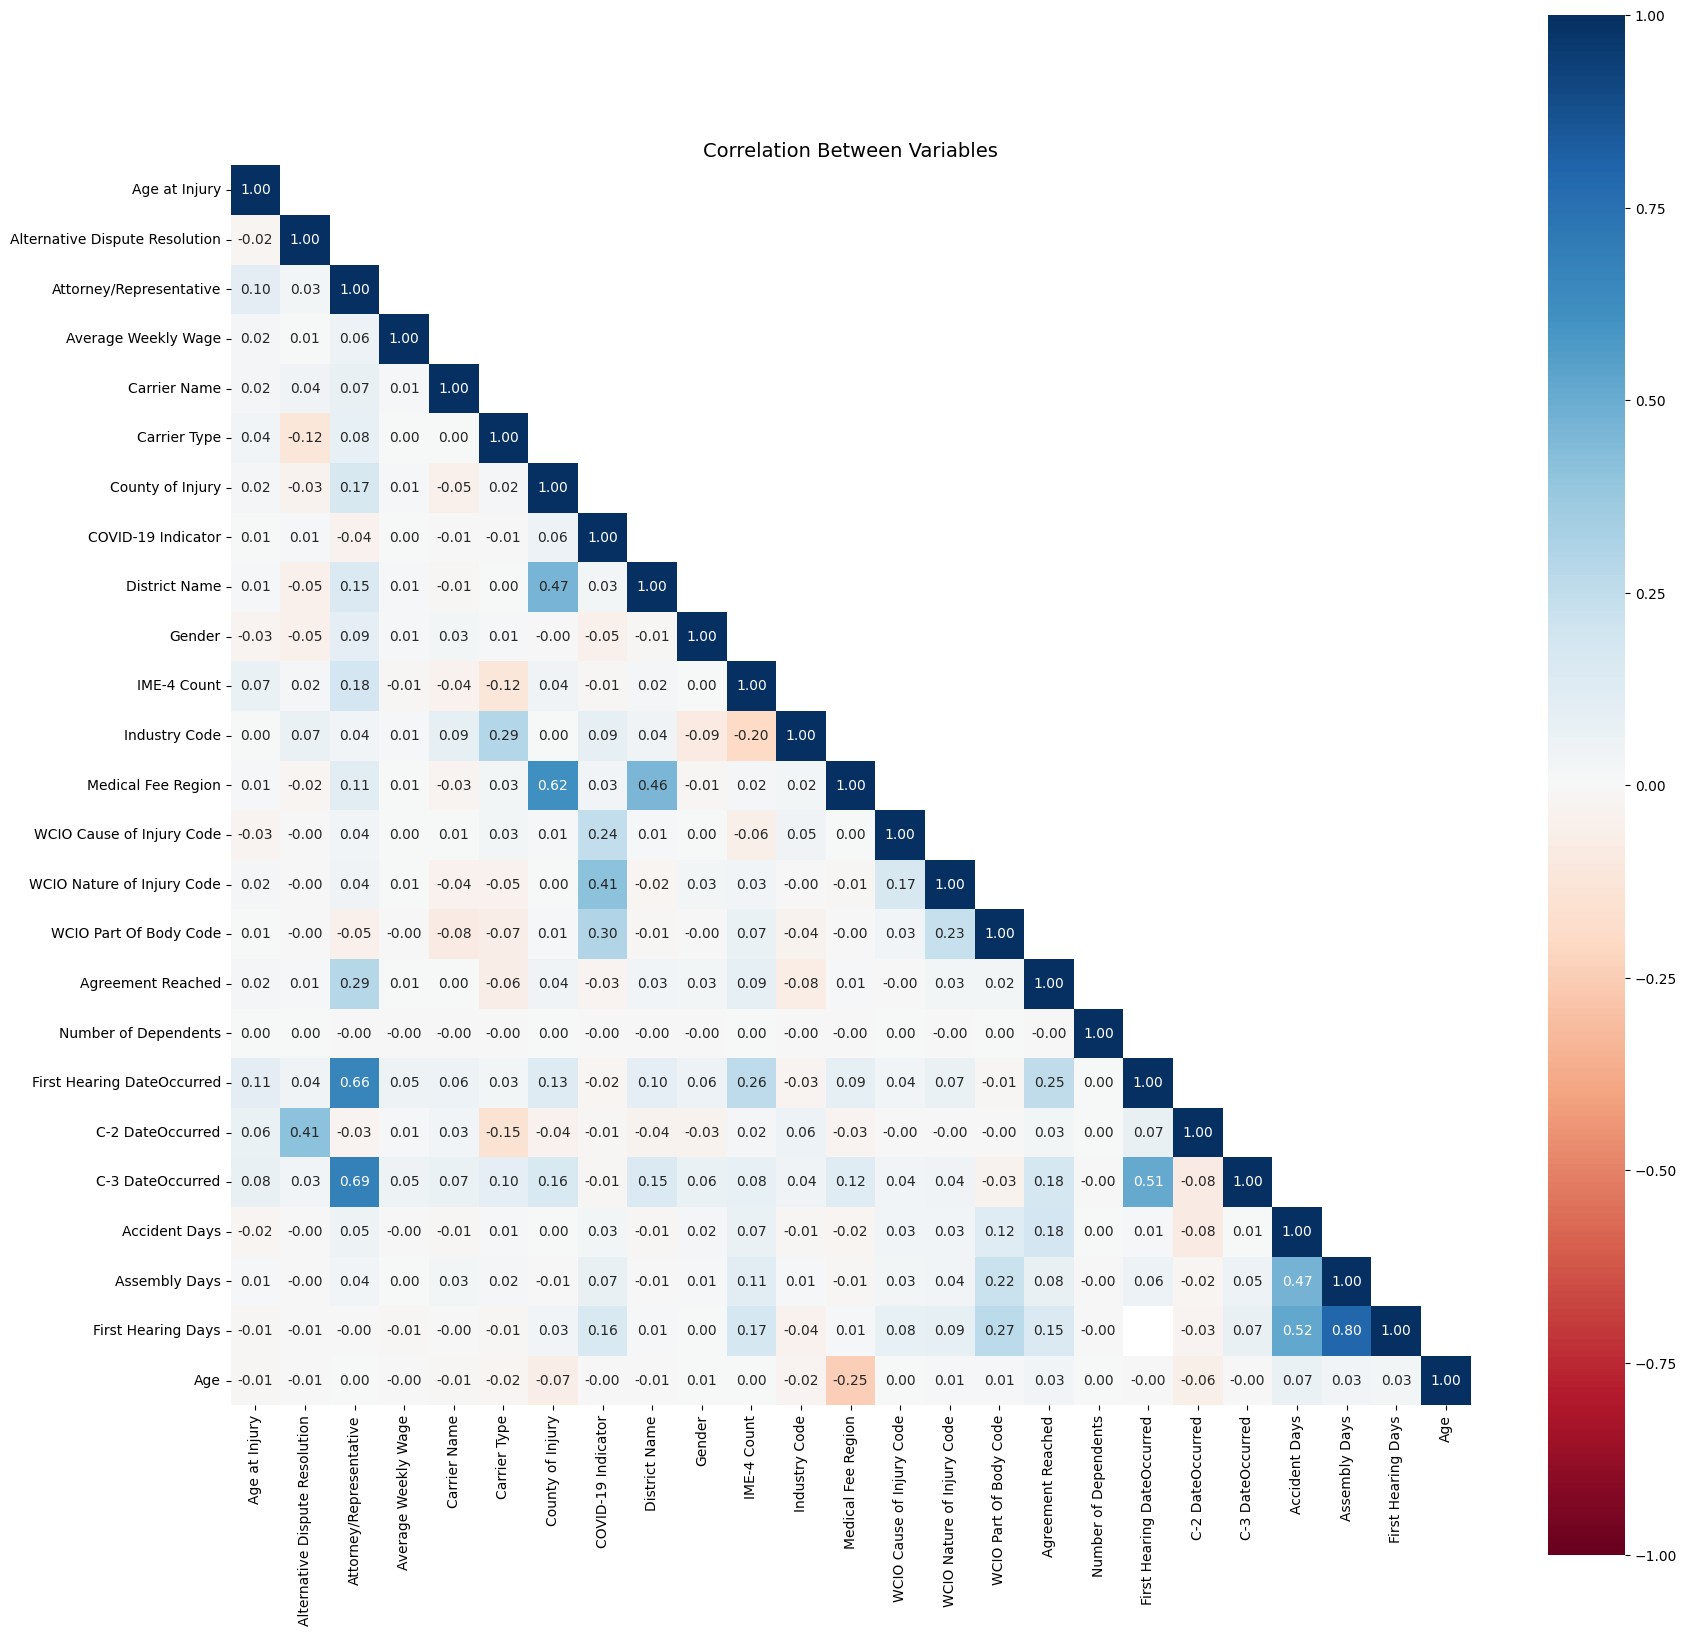

In [32]:
# initial correlation matrix with the respective values
corr_matrix = X.drop(['Zip Code', 'WCB Decision'], axis = 1).corr()

mask = np.tri(*corr_matrix.shape, k=0, dtype=bool)
# Keeps values where mask is True
corr_matrix = corr_matrix.where(mask) 

# defines the figure size
fig, ax = plt.subplots(figsize=(20, 20))
# heatmap of the initial correlation matrix
l = sns.heatmap(corr_matrix, square=True, annot=True, fmt=".2f", vmax=1, vmin=-1, cmap='RdBu', ax=ax)
plt.title('Correlation Between Variables', size=14)
plt.show()

# Model Train

In [27]:
# should do RFE and Lasso to see importance 
# we still have a lot of missing values and things to do before we start modeling

In [28]:
def metrics(y_train, pred_train , y_val, pred_val):
 print('___________________________________________________________________________________________________________')
 print(' TRAIN ')
 print('-----------------------------------------------------------------------------------------------------------')
 print('accuracy score = ',accuracy_score(y_train, pred_train))
 print('___________________________________________________________________________________________________________')
 print(' VALIDATION ')
 print('-----------------------------------------------------------------------------------------------------------')
 print('accuracy score = ',accuracy_score(y_val, pred_val))

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
X = X.drop(['Zip Code', 'WCB Decision'], axis=1)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.25, random_state = 42, stratify = y, shuffle = True)
mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_val = mm.transform(X_val)
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=None).fit(X_train, y_train)
dt_train_pred = dt.predict(X_train)
dt_val_pred = dt.predict(X_val)
print(' dt evaluation ')
metrics(y_train, dt_train_pred, y_val, dt_val_pred)

 dt evaluation 
___________________________________________________________________________________________________________
 TRAIN 
-----------------------------------------------------------------------------------------------------------
accuracy score =  0.7757915446240468
___________________________________________________________________________________________________________
 VALIDATION 
-----------------------------------------------------------------------------------------------------------
accuracy score =  0.776442960970545


# Predict Test

In [32]:
test_df = pd.read_csv("./data/test_data.csv")